In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns
import random as random
from datetime import datetime,timedelta

In [2]:
import matplotlib.pyplot as plt

In [3]:
def generate_sales_data(num_order=100):
    start_date = datetime(2025,1,1)
    end_date = datetime(2025,12,31)
    data = {
        'order_id': range(1,num_order+1),
        'customer_id':[random.randint(100,200) for _ in range(num_order)],
        'product':[random.choice(['Book','Laptop','Pen','Bag']) for _ in range(num_order)],
        'quantity':[random.randint(1,10) for _ in range(num_order)],
        'price':[random.randint(100,1000) for _ in range(num_order)],
        'date': [
            (start_date + timedelta(days=random.randint(0, (end_date-start_date).days),
                                    hours=random.randint(0,23))).strftime("%Y-%m-%d %H:%M:%S")
            for _ in range(num_order)
        ]

    }
    return pd.DataFrame(data)


df = generate_sales_data(num_order=5000)
print(df.head())

   order_id  customer_id product  quantity  price                 date
0         1          158    Book         9    372  2025-02-01 12:00:00
1         2          170  Laptop         7    322  2025-08-29 19:00:00
2         3          124    Book         6    316  2025-11-10 07:00:00
3         4          100     Bag        10    840  2025-03-20 00:00:00
4         5          137  Laptop         4    496  2025-10-23 10:00:00


In [4]:
df['Total_Sales'] = df['quantity'] * df['price']

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
avg_price_cat = df.groupby('product')['price'].mean().sort_values(ascending=False)
print(avg_price_cat)

product
Book      555.660256
Pen       553.793265
Laptop    549.735818
Bag       545.594682
Name: price, dtype: float64


In [7]:
weekly_sales = df.set_index('date')['Total_Sales'].resample('W').sum()

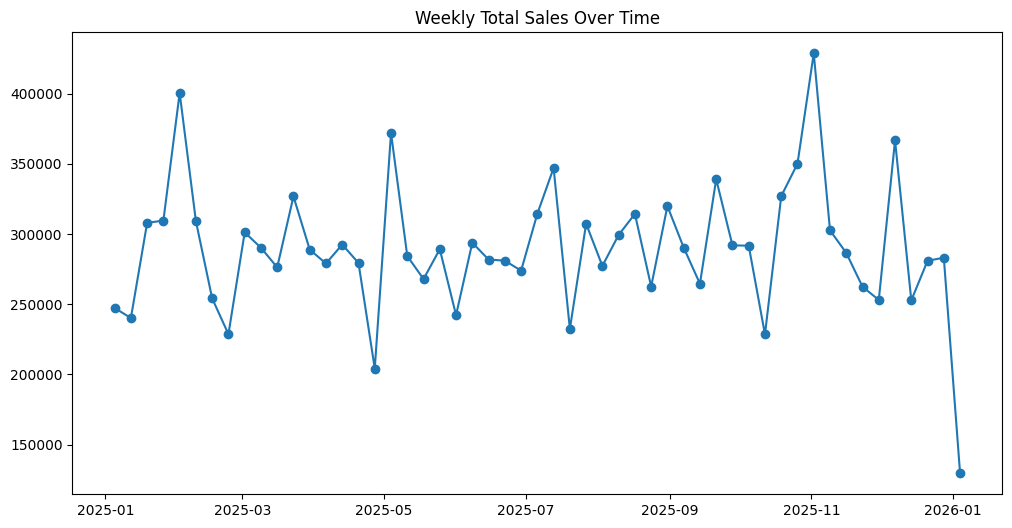

In [8]:
plt.figure(figsize=(12,6))
plt.plot(weekly_sales,marker='o')
plt.title('Weekly Total Sales Over Time')
plt.show()

In [9]:
customer_sales = df.groupby('customer_id')['Total_Sales'].sum().sort_values(ascending=False)

In [10]:
print(customer_sales.head(10))

customer_id
118    213684
166    213500
143    212265
192    207758
190    201931
114    195416
199    192662
145    190131
147    189941
153    188703
Name: Total_Sales, dtype: int64


In [11]:
cum_sales = customer_sales.cumsum()
cum_pct = 100 * cum_sales / customer_sales.sum()

In [12]:
top_50_pct_count = len(cum_pct[cum_pct <= 50])
print(f'{top_50_pct_count} customer account for 50% of total revenue')

43 customer account for 50% of total revenue


In [13]:
reference_date = df['date'].max() + pd.Timedelta(days=1)

In [14]:
rfm = df.groupby('customer_id').agg({
    'date':lambda x: (reference_date - x.max()).days,
    'order_id':'count',
    'Total_Sales':'sum'
})

rfm.rename(columns={'date':'Recency','order_id':'Frequency','Total_Sales':'Monetary'},inplace=True)

In [15]:
rfm[
    'R_Score'
] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])

rfm[
    'F_Score'
] = pd.qcut(rfm['Frequency'],5,labels=[1,2,3,4,5])

rfm[
    'M_Score'
] = pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])

In [16]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [17]:

best_customers = rfm[rfm['RFM_Score'] == '555']   # Champions


In [18]:


print("Best Customers (IDS)",best_customers.index.tolist())

Best Customers (IDS) [114, 118, 136, 143, 190, 199]


In [19]:
df['Hour'] = df['date'].dt.hour
hourly_sales = df.groupby('Hour')['Total_Sales'].sum()
print(hourly_sales)

Hour
0     701505
1     626701
2     710721
3     740070
4     700964
5     530746
6     710033
7     616495
8     664193
9     558677
10    493192
11    662888
12    655625
13    736607
14    576634
15    638382
16    554023
17    654924
18    601962
19    642865
20    664269
21    640174
22    588517
23    656048
Name: Total_Sales, dtype: int64


In [23]:
df['DayOfWeek']  = df['date'].dt.day_name()

In [24]:
heatmap_data = df.pivot_table(index ='DayOfWeek', columns='Hour', values='Total_Sales', aggfunc='count')

In [25]:
print(heatmap_data)

Hour       0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
DayOfWeek                                          ...                       
Friday     30  21  37  33  17  22  36  38  38  26  ...  20  29  31  22  26   
Monday     36  43  19  45  37  28  29  30  25  32  ...  20  42  29  43  30   
Saturday   31  25  26  31  27  31  18  33  37  26  ...  33  45  19  27  24   
Sunday     35  38  25  28  29  35  33  23  27  16  ...  26  29  27  25  27   
Thursday   30  21  27  29  37  31  29  36  30  22  ...  33  32  36  27  28   
Tuesday    34  34  36  29  35  15  32  25  26  32  ...  27  31  24  25  26   
Wednesday  28  25  44  27  30  27  30  20  35  34  ...  25  24  24  35  29   

Hour       19  20  21  22  23  
DayOfWeek                      
Friday     25  36  28  27  43  
Monday     31  23  22  25  30  
Saturday   27  41  31  35  25  
Sunday     30  22  34  27  38  
Thursday   32  46  36  27  22  
Tuesday    25  32  31  30  35  
Wednesday  33  33  26  22  24  

[7 rows 

In [26]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days)

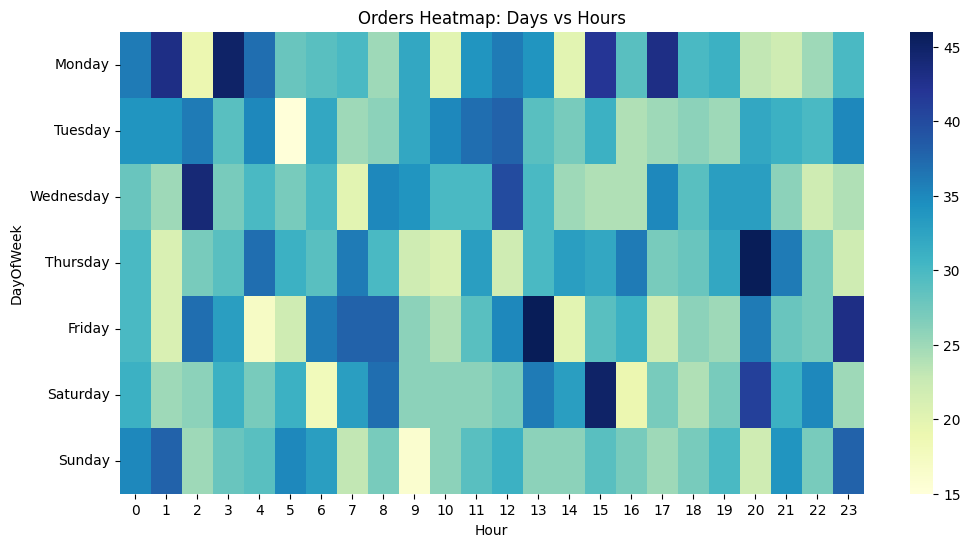

In [27]:
plt.figure(figsize = (12,6)) 
sns.heatmap(heatmap_data,cmap='YlGnBu',annot=False)
plt.title('Orders Heatmap: Days vs Hours')
plt.show()
           

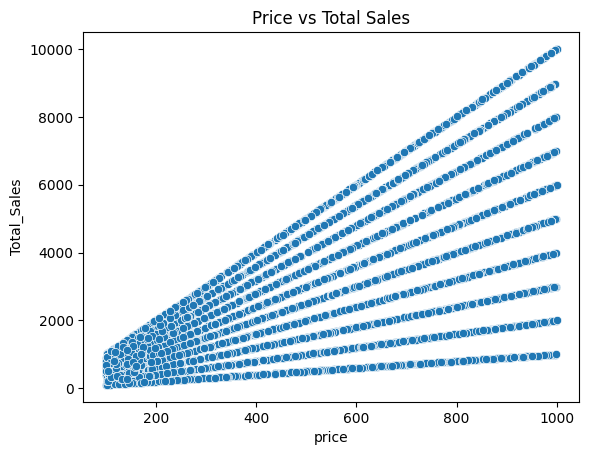

In [28]:
sns.scatterplot(data=df, x='price', y='Total_Sales')
plt.title('Price vs Total Sales')
plt.show()

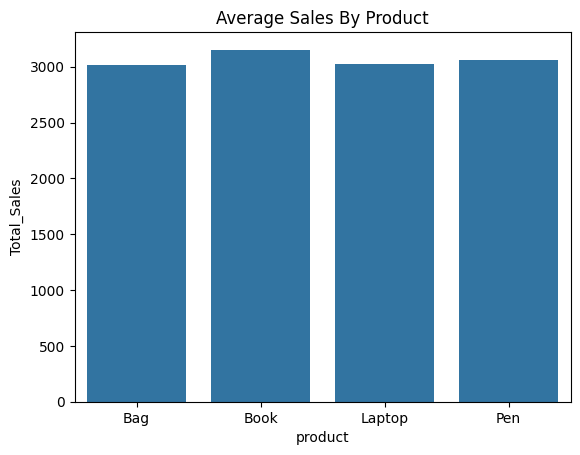

In [29]:
avg_sales = df.groupby('product')['Total_Sales'].mean().reset_index()
sns.barplot(data=avg_sales, x='product',y='Total_Sales')
plt.title('Average Sales By Product')
plt.show()

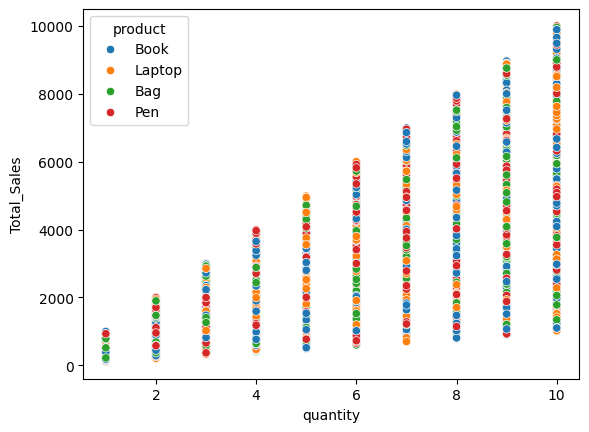

In [30]:
sns.scatterplot(data=df,x='quantity',y='Total_Sales',hue='product')
plt.show()

In [31]:
books = df.loc[df['product'] == 'Book']
print(books)

      order_id  customer_id product  quantity  price                date  \
0            1          158    Book         9    372 2025-02-01 12:00:00   
2            3          124    Book         6    316 2025-11-10 07:00:00   
7            8          143    Book        10    722 2025-03-11 06:00:00   
9           10          111    Book        10    872 2025-07-27 01:00:00   
12          13          166    Book         3    433 2025-10-21 06:00:00   
...        ...          ...     ...       ...    ...                 ...   
4984      4985          149    Book         7    932 2025-04-14 09:00:00   
4986      4987          165    Book         9    119 2025-09-11 11:00:00   
4987      4988          125    Book         7    942 2025-08-04 00:00:00   
4993      4994          126    Book         6    170 2025-06-14 15:00:00   
4997      4998          179    Book         8    404 2025-03-31 22:00:00   

      Total_Sales  Hour DayOfWeek  
0            3348    12  Saturday  
2            18

In [33]:
high_price  = df[df['price'] > 500]
print(high_price.head())
print(high_price.count())

    order_id  customer_id product  quantity  price                date  \
3          4          100     Bag        10    840 2025-03-20 00:00:00   
7          8          143    Book        10    722 2025-03-11 06:00:00   
9         10          111    Book        10    872 2025-07-27 01:00:00   
11        12          102     Pen         5    512 2025-03-03 07:00:00   
13        14          146     Pen         3    702 2025-01-08 12:00:00   

    Total_Sales  Hour  DayOfWeek  
3          8400     0   Thursday  
7          7220     6    Tuesday  
9          8720     1     Sunday  
11         2560     7     Monday  
13         2106    12  Wednesday  
order_id       2787
customer_id    2787
product        2787
quantity       2787
price          2787
date           2787
Total_Sales    2787
Hour           2787
DayOfWeek      2787
dtype: int64


In [35]:
books_high_qty = df[(df['product'] == 'Book') & (df['quantity'] > 5)]
print(books_high_qty)

      order_id  customer_id product  quantity  price                date  \
0            1          158    Book         9    372 2025-02-01 12:00:00   
2            3          124    Book         6    316 2025-11-10 07:00:00   
7            8          143    Book        10    722 2025-03-11 06:00:00   
9           10          111    Book        10    872 2025-07-27 01:00:00   
21          22          147    Book         9    332 2025-01-12 00:00:00   
...        ...          ...     ...       ...    ...                 ...   
4984      4985          149    Book         7    932 2025-04-14 09:00:00   
4986      4987          165    Book         9    119 2025-09-11 11:00:00   
4987      4988          125    Book         7    942 2025-08-04 00:00:00   
4993      4994          126    Book         6    170 2025-06-14 15:00:00   
4997      4998          179    Book         8    404 2025-03-31 22:00:00   

      Total_Sales  Hour DayOfWeek  
0            3348    12  Saturday  
2            18

In [36]:
grouped = df.groupby('product').filter(lambda x: x['Total_Sales'].sum() > 10000)
print(grouped)

      order_id  customer_id product  quantity  price                date  \
0            1          158    Book         9    372 2025-02-01 12:00:00   
1            2          170  Laptop         7    322 2025-08-29 19:00:00   
2            3          124    Book         6    316 2025-11-10 07:00:00   
3            4          100     Bag        10    840 2025-03-20 00:00:00   
4            5          137  Laptop         4    496 2025-10-23 10:00:00   
...        ...          ...     ...       ...    ...                 ...   
4995      4996          150     Pen         3    666 2025-12-19 22:00:00   
4996      4997          143     Pen         2    289 2025-03-15 09:00:00   
4997      4998          179    Book         8    404 2025-03-31 22:00:00   
4998      4999          105     Pen         6    500 2025-07-25 11:00:00   
4999      5000          134     Bag         4    609 2025-01-14 21:00:00   

      Total_Sales  Hour DayOfWeek  
0            3348    12  Saturday  
1            22